
https://www.tensorflow.org/tutorials/keras/save_and_load

In [1]:
!pip install datasets

In [2]:
# апи прикручиваем
!pip install -q kaggle

from google.colab import files
import os

# диалогово подгружаем токен
uploaded = files.upload()

# делаем путь
!mkdir -p ~/.kaggle

# помещаем токен)
for fn in uploaded.keys():
  !cp "{fn}" ~/.kaggle/kaggle.json

# делаем доступ
!chmod 600 ~/.kaggle/kaggle.json

# чек
!ls -l ~/.kaggle/

# грузим датасет по пути из кеггля
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

# анпакинг
!unzip imdb-dataset-of-50k-movie-reviews.zip

Saving kaggle (1).json to kaggle (1) (3).json
total 4
-rw------- 1 root root 68 May 20 11:48 kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  imdb-dataset-of-50k-movie-reviews.zip
replace IMDB Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: IMDB Dataset.csv        


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#смотрим
df = pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Теперь нужно подготовить дату

In [4]:
# диагностика

df.info()
print(df.isnull().sum())

# без НаНов, объектные, сбалансированные - супер

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
review       0
sentiment    0
dtype: int64


In [5]:
# вооружаемся еще библиотеками
import re
import requests
import nltk
import spacy
import tensorflow as tf
import tensorflow_text as tf_text
from nltk.tokenize import sent_tokenize, word_tokenize

In [6]:
# выравниваем регистр
df['review'] = df['review'].apply(lambda x: x.lower())

print(df['review'].head())

0    one of the other reviewers has mentioned that ...
1    a wonderful little production. <br /><br />the...
2    i thought this was a wonderful way to spend ti...
3    basically there's a family where a little boy ...
4    petter mattei's "love in the time of money" is...
Name: review, dtype: object


In [7]:
# зачищаем регексом всякие неправильные штуки
# говорим "нет"
def clean_review(review):
    review = re.sub(r'<[^>]+>', '', review) # хтмл тегам
    review = re.sub(r'http\S+|www\S+', '', review) # ссылкам
    review = re.sub(r'[^a-zA-Z0-9\s]', '', review) # лишним символам кроме букв-цифр-пробелов
    review = re.sub(r'\s+', ' ', review).strip() # лишним пробелам
    return review

df['review'] = df['review'].apply(clean_review) # обновляем дф с учетом изменений

print(df['review'].head()) # проверяем

0    one of the other reviewers has mentioned that ...
1    a wonderful little production the filming tech...
2    i thought this was a wonderful way to spend ti...
3    basically theres a family where a little boy j...
4    petter matteis love in the time of money is a ...
Name: review, dtype: object


In [8]:
# самое интересное - токенизация и зачистка стоп слов
from nltk.corpus import stopwords

nltk.download('stopwords') # грузим

stop_words = set(stopwords.words('english')) # делаем сет

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words] # как будет перебирать

df['review'] = df['review'].apply(lambda x: x.split())  # токенизируем
df['review'] = df['review'].apply(remove_stopwords)  # убираем
df['review'] = df['review'].apply(lambda x: " ".join(x))  # и обратно в строку

print(df.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                              review sentiment
0  one reviewers mentioned watching 1 oz episode ...  positive
1  wonderful little production filming technique ...  positive
2  thought wonderful way spend time hot summer we...  positive
3  basically theres family little boy jake thinks...  negative
4  petter matteis love time money visually stunni...  positive


Готовим для модели

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#создаем токенизатор
tokenizer = Tokenizer(num_words=50000, oov_token="")

# применяем
tokenizer.fit_on_texts(df['review'])

# преобразуем в индексы и пэддим до одной длинф
X = tokenizer.texts_to_sequences(df['review'])
max_length = 50
X_pad = pad_sequences(X, maxlen=max_length, padding='post', truncating='post')

# смотрим пример последовательностт
print(X_pad[45])

[11128   100    32     2 10443   115   134  1017    62   105   567  1135
  1383  1540     2   102 11825   172   567   101 11825   175   567    63
   152   387  1984   816    83    14   118   229 36482    29   268   747
    48     4    40   390     2  2271  1462   957   567  4373  1030     2
    13  1576]


In [10]:
#делаем выборки
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X_pad, df['sentiment'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Проверим размеры выборок
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (40000, 50)
Размер валидационной выборки: (5000, 50)
Размер тестовой выборки: (5000, 50)


In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

import numpy as np # этой пока не было :(
# проверка значений
print(np.unique(y_train))

[0 1]


Переходим к созданию модели

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal

model = Sequential()
model.add(Embedding(input_dim=50000, output_dim=128))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # конкретно этот выходной слой с 1 нейроном и сигмоидной активацие говорит, что модель нужна для бинарной классификации)

In [13]:
#компилируем
model.compile(optimizer=Adam(learning_rate=0.0001), # оптимизатор для низкого темпа
              loss='binary_crossentropy', # измеряет, насколько "далеко" предсказанные вероятности от истинных меток и учит минимизироваь
              metrics=['accuracy']) #делаем метрику для удобочитаемсти

Обучение!

In [14]:
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 95s 146ms/step - accuracy: 0.5669 - loss: 0.6664 - val_accuracy: 0.7802 - val_loss: 0.4668
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 87s 138ms/step - accuracy: 0.8400 - loss: 0.3686 - val_accuracy: 0.8012 - val_loss: 0.4393
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 87s 139ms/step - accuracy: 0.9110 - loss: 0.2376 - val_accuracy: 0.7984 - val_loss: 0.4784
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 139ms/step - accuracy: 0.9586 - loss: 0.1343 - val_accuracy: 0.7832 - val_loss: 0.5736
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 139ms/step - accuracy: 0.9851 - loss: 0.0649 - val_accuracy: 0.7806 - val_loss: 0.7000
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 76s 122ms/step - accuracy: 0.9969 - loss: 0.0238 - val_accuracy: 0.7780 - val_loss: 0.8457
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 115ms/step - accuracy: 0.9992 - loss: 0.0088 - val_accuracy: 0.7734 - val_loss: 0.9817
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 72s 116ms/step - accuracy: 1.0000 - loss:

Оценка модели

In [15]:
# тест
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

# модель стабильная, но все же переобученная - нужно сжать, или можно было сделать меньше эпох обучения.

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7749 - loss: 1.2821
Test accuracy: 77.84%


In [16]:
from sklearn.metrics import classification_report, confusion_matrix

# Предсказания на тестовой выборке
y_pred = model.predict(X_test)

# Переводим вероятности в метки классов
y_pred = (y_pred > 0.5).astype(int)

# Генерация отчета с метриками
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Генерация матрицы ошибок
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.78      0.78      2462
           1       0.78      0.78      0.78      2538

    accuracy                           0.78      5000
   macro avg       0.78      0.78      0.78      5000
weighted avg       0.78      0.78      0.78      5000

Confusion Matrix:
[[1912  550]
 [ 558 1980]]


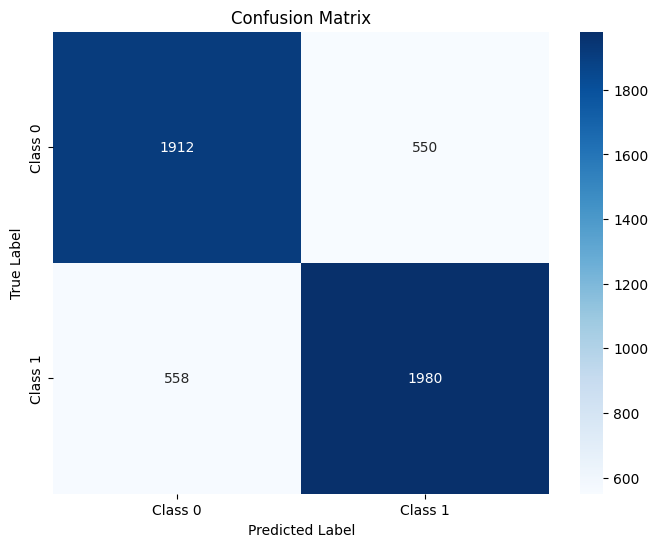

In [17]:
# Визуализация матрицы ошибок
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()